# Homework Lecture 1

### 1.0 Setup:

At the beginning of every Python script, necessary packages should be downloaded, installed, and imported. Excellent free Python ressources are provided by e.g. [QuantEcon.org](https://quantecon.org/ "QuantEcon.org"). In case you are unfamiliar with certain toolboxes or Python syntax you should definately consider giving it a look. Moreover, the Python community is quite big and answers to questions can usually be found after a quick Google search.

In [2]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp 
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

### 1.1 Data:
For this lecture I chose a COVID-19 example. Free COVID-19 data for Norway can for example be obtained from [covid19data.no](https://www.covid19data.no/index.html "COVID Norway"). The website offers healthcare data, data on mobility, and data on business compensations and unemployment benefits. You are of course free to choose your own example. 

Here, I downloaded data on infections, data on mobility based on APPLE mobility trends, as well as data on COVID-19 testing. Let's suppose that we are interested in finding out whether changing our behaviour by e.g. walking or taking the car instead of public transport can reduce the number of infections. (Please keep in mind, that this is a highly stylized example that should be taken with a grain of salt.) Thus we are interested in estimating the model:

$$ infections_t = \alpha + \beta_1 \cdot walking_t + \beta_2 \cdot transit_t + \beta_3 \cdot driving_t + \sum_{i=4}^k\beta_i \cdot C_{i,t} + \varepsilon_t$$


Accordingly, we will regress infections data on the mobility trends data and some control variables. To control for more tests leading to more positive results and hence more infections, the control variables include the number of COVID-19 tests conducted. 

Let's first read-in the data:

In [3]:
# read in the four data sets
infections = pd.read_csv('municipality.csv')
mobilityAPPL = pd.read_csv('mobilityAPPL.csv')
testing = pd.read_csv('national_tests.csv')

# convert the date column to datetime format
infections['date'] = infections['date'].astype('datetime64[ns]')
mobilityAPPL['date'] = mobilityAPPL['date'].astype('datetime64[ns]')
testing['date'] = testing['date'].astype('datetime64[ns]')

Let's have a quick look at the data

In [4]:
# set the date column as the index variable
infections = infections.set_index('date')
mobilityAPPL = mobilityAPPL.set_index('date')
testing = testing.set_index('date')

# sort the testing data in ascending order (it is the other way round in the raw data)
testing = testing.sort_values(by='date', ascending=True)

# A useful method to get a quick look at a data frame
infections.head() 

,date_time,kommune_no,kommune_name,fylke_no,fylke_name,population,cases
date,,,,,,,
2020-03-26,2020-03-26T04:00:00Z,301,Oslo,3,Oslo,693494,743
2020-03-26,2020-03-26T04:00:00Z,1101,Eigersund,11,Rogaland,14811,6
2020-03-26,2020-03-26T04:00:00Z,1103,Stavanger,11,Rogaland,143574,87
2020-03-26,2020-03-26T04:00:00Z,1106,Haugesund,11,Rogaland,37357,41
2020-03-26,2020-03-26T04:00:00Z,1108,Sandnes,11,Rogaland,79537,34


After a quick look at the other dataframes (omitted here) we realise that the datasets are not alligned. We hence need to adjust the samples. Moreover, since the testing data is only available at national level, we have to aggregate the data across municipalities. We hence have to sum up all the cases that were recorded in different municipalities for every day. Moreover, to get rid of nonlinear trends in the data we will also take log-differences of the individual series (the logarithm "linearises" non-linear trends. Differecing then simply substracts these from the data). 

In [5]:
# Allign the sample length
infections = infections['2020-04-01':'2020-12-22']
mobilityAPPL = mobilityAPPL['2020-04-01':'2020-12-22']
testing = testing['2020-04-01':'2020-12-22']

# aggregate the daily infections data across municipalities. Parsing the argument as a list "[['cases']]" 
# automatically results in a new pd.DataFrame. Here we simply sum up the cases for every day.
infections = infections.groupby('date')[['cases']].sum()

# take log-differences of the cases
infections['ld_cases'] = np.log(infections.cases) - np.log(infections.cases.shift(1))

# take log-differences of the testing data. Since there is days with zero tests conducted,
# we add a small epsilon to avoid taking logs of 0! 
testing['ld_ntests'] = np.log(testing.n_tests + 10**-13 ) - np.log(testing.n_tests.shift(1) + 10**-13)

# mobility APPL already provides aggregated data. 
mobilityAPPL = mobilityAPPL[mobilityAPPL['region']=='Norway']

# extract the mobility trends by type and rename the value column. Take log-differences
driving = mobilityAPPL.loc[mobilityAPPL['transportation_type'] == 'driving', ['val']]
driving.rename(columns = {'val':'ld_driving'}, inplace = True)
driving.ld_driving =  np.log(driving.ld_driving) - np.log(driving.ld_driving.shift(1))

transit = mobilityAPPL.loc[mobilityAPPL['transportation_type'] == 'transit', ['val']]
transit.rename(columns = {'val':'ld_transit'}, inplace = True)
transit.ld_transit = np.log(transit.ld_transit) - np.log(transit.ld_transit.shift(1))

walking = mobilityAPPL.loc[mobilityAPPL['transportation_type'] == 'walking', ['val']]
walking.rename(columns = {'val':'ld_walking'}, inplace = True)
walking.ld_walking = np.log(walking.ld_walking) - np.log(walking.ld_walking.shift(1))

Let's collect the data into one dataframe. In order to do so, we use panda's "merge" function, where we merge using the date column. Once the merging is completed, we can drop all rows that contain missing values in one of the variables. Also let's add 10 lags of the dependent variable, which corresponds to the length of quarantine in Norway. The idea is that after 10 days patients that are infected will usually have developed symptoms and hence got tested. Hence, if more people are infected now, this should have a positive effect on infections over the next 10 days. 

In [6]:
# define the list of dataframes to be merged
dfs = [infections, driving, transit, walking, testing[['ld_ntests']]] 

# merge the datasets specified in 'dfs'. Here we use and one-line lambda function
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'], how='outer'), dfs)

# drop rows that contain missing values
df_merged = df_merged.dropna()

# add a lagged dependent variables
df_merged['ld_cases_1'] = df_merged.ld_cases.shift(1)
df_merged['ld_cases_2'] = df_merged.ld_cases.shift(2)
df_merged['ld_cases_3'] = df_merged.ld_cases.shift(3)
df_merged['ld_cases_4'] = df_merged.ld_cases.shift(4)
df_merged['ld_cases_5'] = df_merged.ld_cases.shift(5)
df_merged['ld_cases_6'] = df_merged.ld_cases.shift(6)
df_merged['ld_cases_7'] = df_merged.ld_cases.shift(7)
df_merged['ld_cases_8'] = df_merged.ld_cases.shift(8)
df_merged['ld_cases_9'] = df_merged.ld_cases.shift(9)
df_merged['ld_cases_10'] = df_merged.ld_cases.shift(10)

df_merged = df_merged.dropna()
df_merged = df_merged[['ld_cases', 'ld_cases_1', 'ld_cases_2', 'ld_cases_3'
                       , 'ld_cases_4', 'ld_cases_5', 'ld_cases_6', 'ld_cases_7'
                       , 'ld_cases_8', 'ld_cases_9', 'ld_cases_10',
                       'ld_driving', 'ld_transit', 'ld_walking', 'ld_ntests']]

We have now successfully extracted the data we need and completed some initial data cleaning. 

In [7]:
df_merged.head()

,ld_cases,ld_cases_1,ld_cases_2,ld_cases_3,ld_cases_4,ld_cases_5,ld_cases_6,ld_cases_7,ld_cases_8,ld_cases_9,ld_cases_10,ld_driving,ld_transit,ld_walking,ld_ntests
date,,,,,,,,,,,,,,,
2020-04-16,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.021873,0.057830,0.058005,0.009646,-0.089199,-0.022700,0.751233
2020-04-17,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.021873,0.057830,0.068837,0.052594,0.075716,-0.322364
2020-04-18,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.021873,-0.030563,-0.034201,0.049472,0.305319
2020-04-19,0.011968,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.022257,0.093911,0.008343,-0.317653
2020-04-20,0.006353,0.011968,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.051259,0.031809,0.036527,-0.830231


Let's now have a brief look at the time series. In this context, plotting and eye-balling the data is always a good first step.

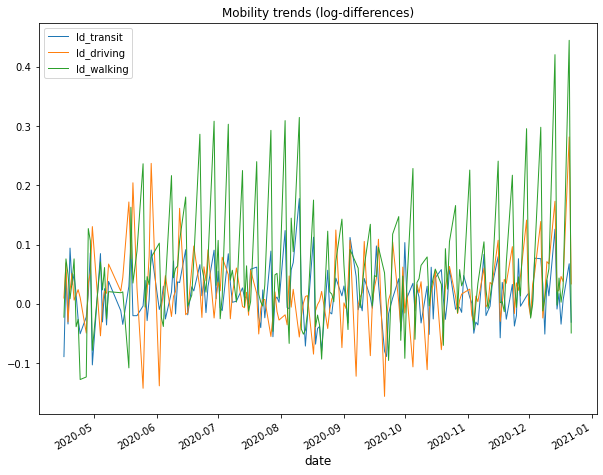

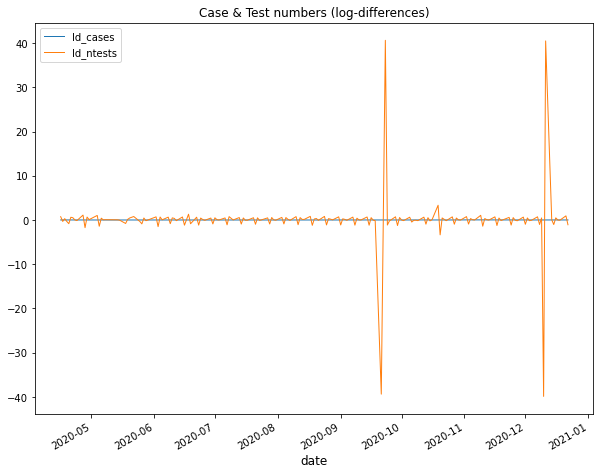

In [8]:
ax = df_merged[['ld_transit','ld_driving','ld_walking']].plot(lw=1)
ax.set_xlabel('date', fontsize=12)
plt.title("Mobility trends (log-differences)")
plt.show()

ax2 = df_merged[['ld_cases','ld_ntests']].plot(lw=1)
ax2.set_xlabel('date', fontsize=12)
plt.title("Case & Test numbers (log-differences)")
plt.show()

We immediately notice that the data seems to follow a strong seasonal pattern:

* Testing might not be conducted on weekends 
* infections data might only be updated on weekdays
* Compared to weekends, during the week people have to commute to work
* people might take more walks during summer months compared to winter months
* ...

For this reason, we will also add weekday dummies and monthly/seasonal dummies to the regression. 

In [9]:
# ---------------------------------------------------create weekday dummies-------------------------------------------------------------

# specify weekdays 
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# extract weekdays from dates
df_merged['Weekday'] = df_merged.index.weekday

# use pandas "get_dummies" to convert the weekday column into binary indicators/dummies that we join to the dataset
df_merged = df_merged.join(pd.get_dummies(df_merged.Weekday))

# apply the names to the newly created columns
column_indices = list(range(16,23,1))
old_names = df_merged.columns[column_indices]
df_merged.rename(columns=dict(zip(old_names, names)), inplace=True)

# drop the weekday column
df_merged = df_merged.drop(['Weekday'], axis=1)

# ---------------------------------------------------create monthly dummies-------------------------------------------------------------

# specify months (we know that our data starts in April)
names = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_merged['month'] = df_merged.index.month

# use pandas "get_dummies" to convert the month column into binary indicators/dummies that we join to the dataset
df_merged = df_merged.join(pd.get_dummies(df_merged.month))

# apply the names to the newly created columns
column_indices = list(range(23,32,1))
old_names = df_merged.columns[column_indices]
df_merged.rename(columns=dict(zip(old_names, names)), inplace=True)

# drop the month column. Also drop one dummy each due to multicoliniarity
df_merged = df_merged.drop(['month','Monday','Apr'], axis=1)


df_merged

,ld_cases,ld_cases_1,ld_cases_2,ld_cases_3,ld_cases_4,ld_cases_5,ld_cases_6,ld_cases_7,ld_cases_8,ld_cases_9,...,Saturday,Sunday,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
date,,,,,,,,,,,,,,,,,,,,,
2020-04-16,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.021873,0.057830,...,0,0,0,0,0,0,0,0,0,0
2020-04-17,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.021873,...,0,0,0,0,0,0,0,0,0,0
2020-04-18,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,...,1,0,0,0,0,0,0,0,0,0
2020-04-19,0.011968,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,...,0,1,0,0,0,0,0,0,0,0
2020-04-20,0.006353,0.011968,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,0.012499,0.008036,0.004892,0.012493,0.009280,0.011833,0.009768,0.006583,0.010879,0.010339,...,0,0,0,0,0,0,0,0,0,1
2020-12-17,0.010825,0.012499,0.008036,0.004892,0.012493,0.009280,0.011833,0.009768,0.006583,0.010879,...,0,0,0,0,0,0,0,0,0,1
2020-12-18,0.011156,0.010825,0.012499,0.008036,0.004892,0.012493,0.009280,0.011833,0.009768,0.006583,...,0,0,0,0,0,0,0,0,0,1


 ### 1.2 Compute OLS regressions
 
After having compiled our data set, we are now ready to run a regression. As is specified above, we regress the infections data on our mobility trends data, an intercept, as well as the testing data and our dummies. Instead of the equation that we proposed originally, we will estimate the model:

$$ \Delta ln(infections_t) = \alpha + \beta_1 \cdot \Delta ln(walking_t) + \beta_2 \cdot \Delta ln(transit_t) + \beta_3 \cdot \Delta ln(driving_t) + \sum_{i=4}^k\beta_i \cdot C_{i,t} + \varepsilon_t$$

In [40]:
# convert the cases to a numpy array
Y = df_merged.ld_cases.to_numpy()

# convert numpy ndarray to matrix
Y = np.asmatrix(Y)
Y = Y.T

# convert the rest of 
column_indices = list(range(1,29,1))
X = df_merged[df_merged.columns[column_indices]].to_numpy()
X = np.asmatrix(X)

# add the intercept to the RHS/independent variables
X = np.concatenate((np.asmatrix(np.ones(len(X))).T, X), axis=1)

varnames = np.asarray(df_merged.columns[column_indices])
varnames = np.concatenate([['intercept'],varnames])

# compute beta coefficients
beta = np.linalg.inv(X.T @ X) @ (X.T @ Y)

# compute the regression residuals
eps = Y - X @ beta

# compute the residual variance
s_hat = 1/(len(Y)-len(beta)) * eps.T @ eps

# compute the standard errors
se = np.asmatrix(np.sqrt(np.diag(np.linalg.inv(X.T @ X) * s_hat.item())))

# compute t-statistics
t = np.abs(beta/se.T)

# compute p-values using scipy's stats library
p_vals = 2*(1-stats.norm.cdf(np.abs(t)))

# compute confidence intervals
CI_upper = beta + stats.norm.ppf(0.975)*se.T
CI_lower = beta - stats.norm.ppf(0.975)*se.T

# compute R^2
MSE = np.mean(np.square(eps),axis=0)
R2 = 1 - MSE[-1]/np.var(Y)

# create output table
outmat = np.concatenate((beta,se.T,t,p_vals,CI_lower,CI_upper),axis=1)
table = pd.DataFrame(outmat,varnames)
table.columns =['beta', 'se','t-statistic','p-value','CI - lower','CI - upper'] 
print('R^2:', R2.item())
table


R^2: 0.8993357006527442


,beta,se,t-statistic,p-value,CI - lower,CI - upper
intercept,-0.002084,0.001664,1.252646,2.103346e-01,-0.005345,0.001177
ld_cases_1,0.445369,0.083665,5.323253,1.019277e-07,0.281389,0.609348
ld_cases_2,0.273135,0.093428,2.923481,3.461411e-03,0.090020,0.456251
ld_cases_3,0.149934,0.092834,1.615076,1.062943e-01,-0.032017,0.331885
ld_cases_4,-0.124082,0.090979,1.363860,1.726117e-01,-0.302397,0.054233
ld_cases_5,0.320536,0.087005,3.684093,2.295182e-04,0.150009,0.491064
ld_cases_6,-0.141148,0.086386,1.633926,1.022743e-01,-0.310460,0.028165
ld_cases_7,-0.077861,0.083830,0.928799,3.529932e-01,-0.242165,0.086442
ld_cases_8,-0.084893,0.083720,1.014006,3.105797e-01,-0.248981,0.079196
ld_cases_9,0.056010,0.067522,0.829500,4.068214e-01,-0.076331,0.188350


First notice, that the interpretation of our regression coefficients is somewhat tricky! Recall that for small changes log-differences can be interpreted as percentage changes (see an example for $x_{t}=12$ and $x_{t-1} = 11$):


In [41]:
print('log-approximation:')
print((np.log(12)-np.log(11))*100)
print()
print('actual % change:')
print(((12-11)/11)*100)

log-approximation:
8.701137698962969

actual % change:
9.090909090909092


Thus recall that in standard log-log regressions we interpret "A $1$% increase in $X$, leads to a $\beta$% increase in $Y$". We can now use a simple trick:

For 

$$ ln(Y_t) = \alpha + \beta\cdot ln(X_t) $$

we have

$$ ln(Y_t) - ln(Y_{t-1})= \alpha + \beta\cdot ln(X_t) - \alpha - \beta\cdot ln(X_{t-1}) $$

or 

$$ \Delta ln(Y_t)= \beta\cdot \Delta ln(X_t) $$

Notice that this is exactly the same $\beta$! We can hence stick to the general interpretation.

Let's look at "driving" as an example. A 1% increase in APPLE maps request for driving directions, leads to a -0.007% change in infections. An increase in APPLE maps requests for public transport and walking on the other hand, seems to have a positive effect on infections. Neither effect is statistically significant, however. 


